# Mo Ru Surrogate Model using Neural Networks

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

### Read and Dump JSON

In [44]:
import json

filename = '../data/MoRu_sparse.json'
stream = open(filename)
data = json.load(stream)
stream.close()

### Generate Dataset from JSON Dump

The dataset $\mathcal{D} \subset \mathbb{R}_{\ge 0}^{n_\text{samples} \times (n_\text{elements} + n_\text{phases} + 2)}$ is defined as:
$$\mathcal{D} = \{\mathbf{x}_i \, | \, i \in \{1, \dots, n_\text{samples}\}\}$$
where, $\mathbf{x}_i$ is a single sample such that:
$$\mathbf{x}_i = \left\{{T, P, \{c_j \, | \, j \in \mathcal{1, \dots, n_\text{elements}}\}, \{n_\phi \, | \, \phi \in \mathcal{1, \dots, n_\text{phases}}\}}\right\}$$
where, $c_j$ denotes number of moles of element $j$ and $n_\phi$ denotes the number of moles of phase $\phi$.

In [45]:
n_data = len(data)
n_elements = len(data['2']['elements'])
n_phases = len(data['2']['solution phases']) + len(data['2']['pure condensed phases'])
dataset = np.zeros((n_data, n_elements + n_phases + 2))

phase_names = list(data['2']['solution phases'].keys())
phase_names += list(data['2']['pure condensed phases'].keys())
element_names = list(data['2']['elements'].keys())

In [46]:
keys = list(data.keys())
for i in keys:
    dataset[keys.index(i), 0] = data[i]["temperature"]
    dataset[keys.index(i), 1] = data[i]["pressure"]

    for j in range(n_elements):
        if not (data[i]['elements'].get(element_names[j]) is None):
            dataset[keys.index(i), 2 + j] = data[i]["elements"][element_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + j] = 0.0

    for j in range(n_phases):
        if not (data[i]['solution phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["solution phases"][phase_names[j]]["moles"]
        elif not (data[i]['pure condensed phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["pure condensed phases"][phase_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + n_elements + j]

### Filter out zero data

In [47]:
moles_cutoff = 1e-8
non_zero_columns = np.any(np.greater(dataset[:,(2 + n_elements):], moles_cutoff), axis=0)

### Generate Training Data

- Training samples $n_\text{Train} = 0.6 * n_\text{Total}$
- Input $\mathbf{X} = {T, P, \mathbf{c}}$
- Output $\mathbf{y} = {\mathbf{n}_\phi}$

In [48]:
n_training = int(n_data * 0.6)

choice = np.random.choice(range(dataset.shape[0]), size=(n_training,), replace=False)
train_indices = np.zeros(dataset.shape[0], dtype=bool)
train_indices[choice] = True
test_indices = ~train_indices

train = dataset[train_indices]
test = dataset[test_indices]

In [49]:
# X_train = train[:,0:(2 + n_elements)]
X_train = train[:,0:(2 + n_elements)][:,(0,2)]                                  # Only T, Mo

# Change the outputs to 0.0 / 1.0 based on the number of moles of phase
# y_train = (train[:,(2 + n_elements):] > 0.0).astype(float)
y_train = (train[:,(2 + n_elements):][:,non_zero_columns] > 0.0).astype(float)  # Only non-zero phases

# Use the original moles 
# y_train = train[:,(2 + n_elements):]
# y_train = train[:,(2 + n_elements):][:,non_zero_columns]                      # Only non-zero phases

In [50]:
# Convert to Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train_unscaled = X_train.detach().clone()
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train_unscaled = y_train.detach().clone()

In [51]:
# Calculate mean and standard deviation of inputs
X_mean = X_train.mean(0,keepdim=True)
X_std = X_train.std(0,keepdim=True)

# Standard deviation of pressure is equal to 0.0. Change this to 1.0 to avoid division by zero when scaling
X_std[X_std == 0] = 1.0

# Scale inputs to mean 0 and standard deviation 1 for better convergence
X_train = (X_train - X_mean) / X_std

### Test Data

In [52]:
# Scale test input values to mean 0 and standard deviation 1 based on values from before
# X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)], dtype=torch.float32)
X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)][:,(0,2)], dtype=torch.float32)      # Only T, Mo
X_test = (X_test_unscaled - X_mean) / X_std

# 0 / 1 Output case
# y_test = (test[:,(2 + n_elements):] > 0.0).astype(float)
y_test = (test[:,(2 + n_elements):][:,non_zero_columns] > 0.0).astype(float)                  # Only non-zero phases

# Original moles of phase
# y_test = test[:,(2 + n_elements):]
# y_test = test[:,(2 + n_elements):][:,non_zero_columns]                                      # Only non-zero phases
y_test = torch.tensor(y_test, dtype=torch.float32)

# Combined test and training data
X_all_unscaled = torch.cat([X_train_unscaled, X_test_unscaled])
X_all = torch.cat([X_train, X_test])
y_all = torch.cat([y_train, y_test])

### Input Space Mapping

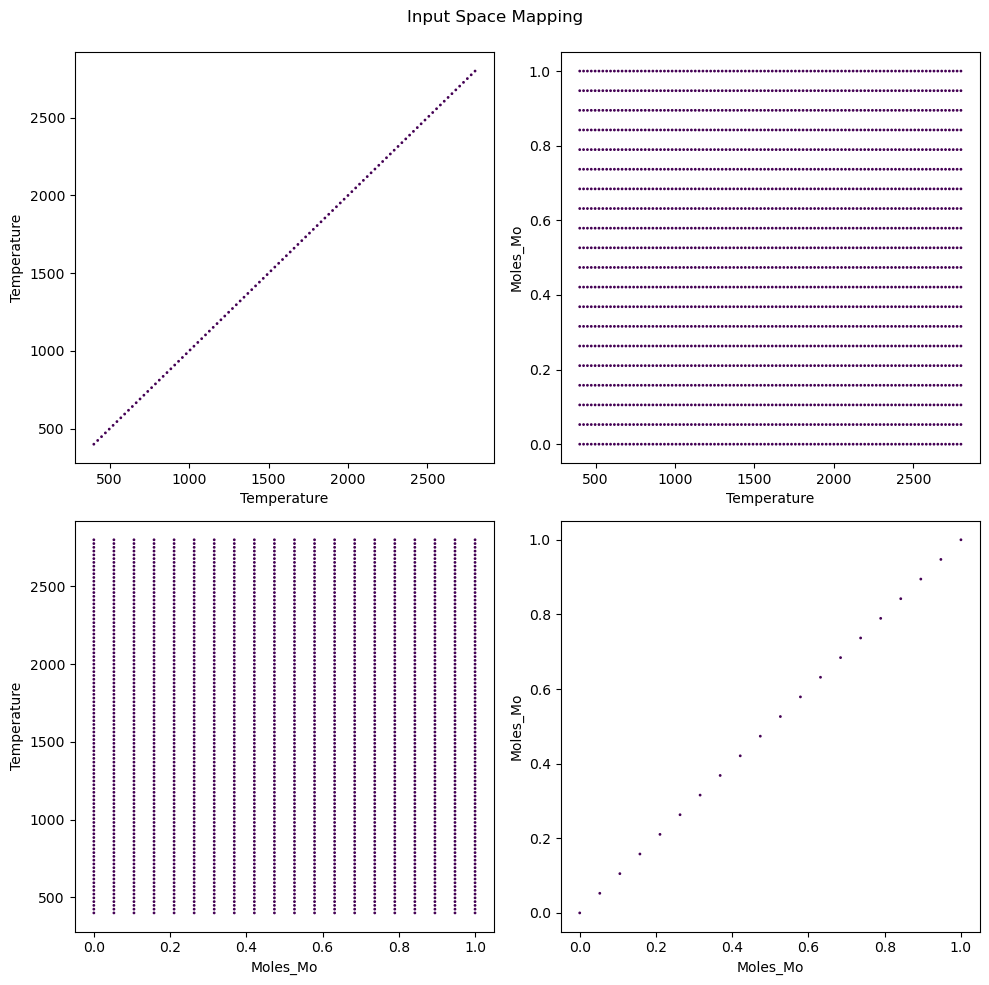

In [53]:
labels = ['Temperature', 'Moles_Mo']
n_columns = len(labels)

fig, ax = plt.subplots(nrows=n_columns, ncols=n_columns, figsize=(10, 10))

for i in range(n_columns):
  for j in range(n_columns):
    reduced, counts = np.unique(np.transpose(np.array([X_all_unscaled[:,i], X_all_unscaled[:,j]])), axis=0, return_counts=True)
    rx, ry = np.transpose(reduced)

    ax[i][j].scatter(rx, ry, c=counts, s=1)
    ax[i][j].set_xlabel(labels[i])
    ax[i][j].set_ylabel(labels[j])

fig.suptitle('Input Space Mapping\n')
fig.tight_layout()

### Softmax Normalization

Applies the Softmax function to output phase moles and rescales the moles to probabilities:
$$\text{Softmax}(x_i) = \frac{\exp{(x_i)}}{\sum_j \exp{(x_j)}}$$

In [54]:
normalization = torch.nn.Softmax(dim=1)
y_train_normalized = normalization(y_train)
y_test_normalized = normalization(y_test)

### Neural Network Model

In [55]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [95]:
input_size = X_test.shape[1]
hidden_size = [10, 10]
output_size = y_test.shape[1]

model = nn.Sequential(
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0], hidden_size[1]),
    nn.ReLU(),
    # nn.Linear(hidden_size[1], hidden_size[2]),
    # nn.ReLU(),
    nn.Linear(hidden_size[1], output_size),
    nn.Sigmoid())

In [96]:
loss_fn = nn.MSELoss()  # Mean Square Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training

In [97]:
n_epochs = 10000
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size]                      # Without softmax normalization
        # ybatch = y_train_normalized[i:i+batch_size]             # With softmax normalization
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}/{n_epochs} - Loss: {loss}')

Finished epoch 0/10000 - Loss: 0.2664496898651123
Finished epoch 1/10000 - Loss: 0.2649054527282715
Finished epoch 2/10000 - Loss: 0.26347023248672485
Finished epoch 3/10000 - Loss: 0.26227396726608276
Finished epoch 4/10000 - Loss: 0.2612988352775574
Finished epoch 5/10000 - Loss: 0.26049357652664185
Finished epoch 6/10000 - Loss: 0.25983431935310364
Finished epoch 7/10000 - Loss: 0.25928717851638794
Finished epoch 8/10000 - Loss: 0.25881731510162354
Finished epoch 9/10000 - Loss: 0.25838229060173035
Finished epoch 10/10000 - Loss: 0.25796210765838623
Finished epoch 11/10000 - Loss: 0.25753405690193176
Finished epoch 12/10000 - Loss: 0.2570610046386719
Finished epoch 13/10000 - Loss: 0.25652429461479187
Finished epoch 14/10000 - Loss: 0.2558540403842926
Finished epoch 15/10000 - Loss: 0.25501370429992676
Finished epoch 16/10000 - Loss: 0.2539706826210022
Finished epoch 17/10000 - Loss: 0.2527921795845032
Finished epoch 18/10000 - Loss: 0.25166600942611694
Finished epoch 19/10000 - Los

###  Evaluation

In [98]:
# Compute accuracy for NN data set
with torch.no_grad():
    y_pred = model(X_all)

### Error Analysis

In [99]:
sorted_indices = (-y_pred).numpy().argsort()
errors = np.zeros(y_all.shape)

for i in range(y_test.shape[0]):
  for j in range(y_test.shape[1]):
    if(y_test[i,j] > 0.0):
      if(j in sorted_indices[i,(0,1)]):
        errors[i,j] = 0.0
      else:
        errors[i,j] = 1.0
    else:
      if(j in sorted_indices[i,(0,1)]):
        errors[i,j] = 0.5
      else:
        errors[i,j] = 0.0

errors_combined = np.max(errors, axis=1)
errors_combined_indices = np.argmax(errors, axis=1)

print(f"NN accuracy (hard error): {np.count_nonzero(errors_combined == 1.0) / errors_combined.shape[0]}")
print(f"NN accuracy (soft error): {np.count_nonzero(errors_combined > 0.0) / errors_combined.shape[0]}")

NN accuracy (hard error): 0.102
NN accuracy (soft error): 0.2975


### Plots

#### Predictions

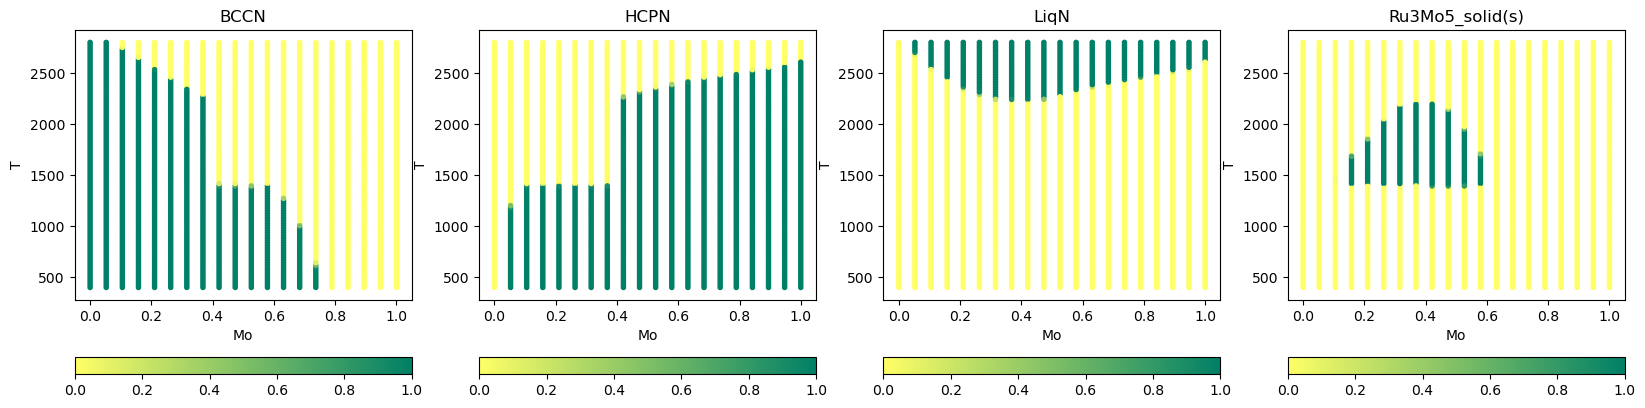

In [61]:
from itertools import compress

active_phases = list(compress(phase_names, non_zero_columns))

fig, axs = plt.subplots(nrows=1, ncols=len(active_phases), figsize=(20,5))

for i in range(len(active_phases)):
  ax  = axs[i]
  ax.set_xlabel('Mo')
  ax.set_ylabel('T')
  ax.set_title(active_phases[i])
  scatter = ax.scatter(X_all_unscaled[:,1].numpy(),
                       X_all_unscaled[:,0].numpy(),
                       c=(y_pred[:,i]).numpy(), marker='.',
                       cmap='summer_r')
  fig.colorbar(scatter, orientation='horizontal', ax=ax)

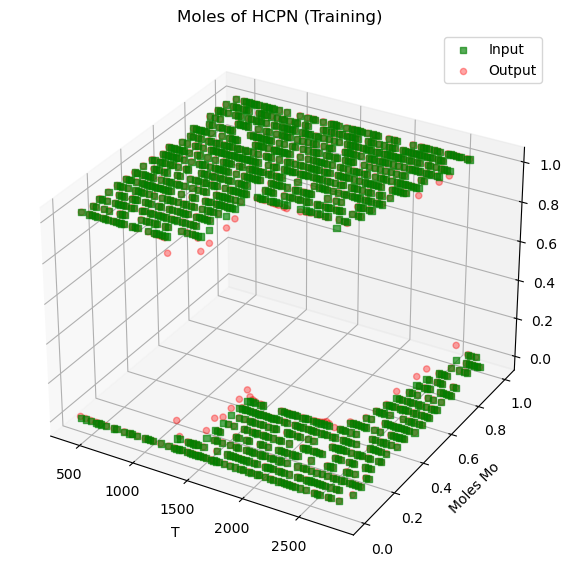

In [62]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Evaluate the model
with torch.no_grad():
    y_pred = model(X_train)

# Creating plot
ax.scatter3D(X_train_unscaled[:,0], X_train_unscaled[:,1], y_train_unscaled[:,1], marker = 's', color = "green", alpha = 0.65, label = "Input")
ax.scatter3D(X_train_unscaled[:,0], X_train_unscaled[:,1], y_pred[:,1], color = "red", alpha = 0.35, label = "Output")
plt.title("Moles of HCPN (Training)")
plt.xlabel("T")
plt.ylabel("Moles Mo")
plt.legend()
plt.show()

IndexError: index 2 is out of bounds for dimension 1 with size 2

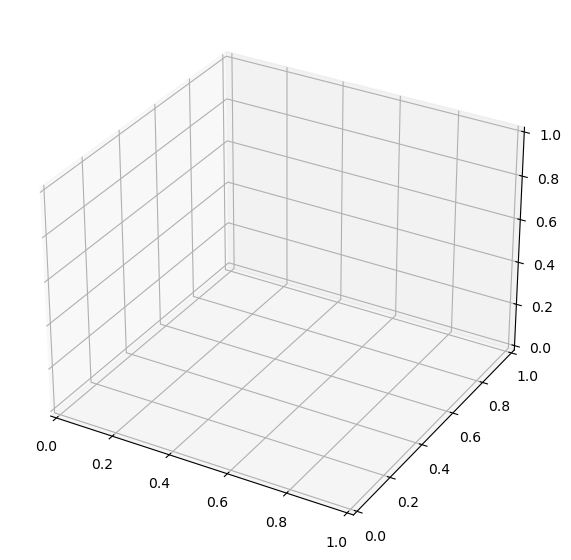

In [63]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test)

# Creating plot
X_test_unscaled = X_test * X_std + X_mean
ax.scatter3D(X_test_unscaled[:,0], X_test_unscaled[:,2], y_test[:,5], marker = 's', color = "green", alpha = 0.65, label = "Input")
ax.scatter3D(X_test_unscaled[:,0], X_test_unscaled[:,2], y_pred[:,5], color = "red", alpha = 0.35, label = "Output")
plt.title("Moles of HCPN (Test)")
plt.xlabel("T")
plt.ylabel("Moles Mo")
plt.legend()
plt.show()


In [ ]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.view_init(elev=10, azim=-30, roll=0)
 
# Evaluate the model
with torch.no_grad():
    y_pred1 = model(X_train)
    y_pred2 = model(X_test)

# NN error
y_pred = torch.cat([y_pred1, y_pred2])
y_err = (y_all - y_pred)

sc = ax.scatter3D(X_all_unscaled[:,0], X_all_unscaled[:,2], y_err[:,5], c=y_err[:,5], cmap='hsv')
fig.colorbar(sc, ax=ax)

plt.title("Moles HCPN (absolute error)")
plt.xlabel("T")
plt.ylabel("Moles Mo")
plt.show()